# Homework 01 

This Jupyter Notebook file is a template that we provide for the homework.
You _must_ use this template and follow the instructions.
You may use codes that were presented in the Lab sessions.
For codes that you have not written (including codes from the Lab) make sure to cite them.


It is important to **carefully read** each assignment and ensure that your answers or code address every part of the assignment.
Make sure to thoroughly understand the requirements before starting.

**Before submitting**, make sure that the entire notebook can be executed with a _fresh_ kernel! (top-left, "Run", "Restart Kernal and Run All Cells") 

<span style="color:red; font-size:18px">**You will fail this homework if the notebook does not run completely.**</span>  
If you cannot solve a part of the tasks, leave them with emphasis (three dots), as shown below.

In [1]:
### DO NOT EDIT
example_var_with_emphesis = ...
###

# Task overview

Your tasks in this homework consist of
1. Downloading a tile.
2. Visualize the tile.
3. Select three representative points for three classes.
4. Creating a 3-class pixel-wise classification map (plus discussion).
5. Applying a smoothing filter.
6. Recreate the 3-class pixel-wise classification map (plus a discussion of differences).
7. Create a binary pixel-wise classification map and run edge detection (plus discussion).

Details to the individual tasks are listed below.

## 1. Downloading a tile.

First you have to download a tile from [Copernicus Dataspace](https://dataspace.copernicus.eu/).
The tile should have the following properties:
- come from the SENTINEL-2 collection
- be from the area of Wismar (you can use the `osmnx` package to get the envelope of the region)
- have a cloud cover of less than 1.0
- be from the time period of June 2023
- be of type L2A (you can filter by the name of the product)

Hint: If you select a region with the `osmnx` package, you can use the envelope of the region as the area of interest (aoi) in the query.
However, as `osmnx` returns a GeoDataFrame, you have to extract the first element of the envelope attribute to get the right envelope, even if it is a single-element GeoSeries.
This element should be of type `shapely.geometry.polygon.Polygon` and can be converted to a WKT string with the `wkt` attribute (e.g., via `region_gdf.envelope[0].wkt`).

If you cannot download the file, please use the following link to download a file:  
https://tubcloud.tu-berlin.de/s/WEz4gRQzfRdwHjk/download/S2A_MSIL2A_20230708T102601_N0509_R108_T32UPE_20230708T181859.SAFE.zip

In [2]:
import osmnx
import rasterio
import numpy as np
from pathlib import Path
import requests
import geopandas
import geopandas as gpd
import pandas as pd
import rasterio.mask

LAB 02 CODE BEGIN

In [3]:
import requests
from pathlib import Path

def get_access_token(username: str, password: str) -> str:
    """
    Get the access token for the Copernicus Data Store. This token is required to access the data for download.
    The token is not required for querying the data. It is valid for 3600 seconds (1 hour).

    ----------
    username : str
        The username for the Copernicus Data Store.
    password : str
        The password for the Copernicus Data Store.
    """
    data = {
        "client_id": "cdse-public",
        "username": username,
        "password": password,
        "grant_type": "password",
    }
    try:
        r = requests.post(
            "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token",
            data=data,
        )
        r.raise_for_status()
    except Exception as e:
        raise Exception(
            f"Access token creation failed. Response from the server was: {r.json()}"
        )
    return r.json()["access_token"]

# you may enter the credentials directly in your notebook
user_name = ""
password = ""

# the following code is for us to not have to share our secrets ;)
user_p = Path("user.txt")
pwd_p = Path("secret.txt")
if user_p.exists():
    user_name = user_p.read_text().strip()
if pwd_p.exists():
    password = pwd_p.read_text().strip()

assert user_name != "", "Please provide your user-name!"
assert password != "", "Please provide your password!"

# return the access token
access_token = get_access_token(user_name, password)

In [4]:
def read_s2_jp2_data_with_clipping(
    band_data_path: Path, clip_geoseries: geopandas.GeoSeries, envelope: bool = True
) -> np.ndarray:
    """
    Given the `band_data_path` to a JP2000 encoded GeoTIFF file, return those parts that are overlapping with the
    `clip_geoseries` GeoSeries. By default, the bounding box (`envelope`) of the geometry will be used to define the
    region of interest.
    """
    # open the GeoTIFF file which also contains the CRS metadata
    with rasterio.open(band_data_path) as data:
        # ensure that the data is using the same coordinate reference system and reproject if they don't
        reprojected_geoseries = clip_geoseries.to_crs(data.crs)
        # use the bounding box if `envelope` is set => Make sure that the matrix we get back can contain
        # only valid values
        reprojected_geoseries = (
            reprojected_geoseries.envelope if envelope else reprojected_geoseries
        )
        # Use crop to only return the matrix that contains our region of interest
        # Use `all_touched=True` to make sure that the border is also conisdered "inside" the region of interest
        out_img, _out_transform = rasterio.mask.mask(
            data, reprojected_geoseries, crop=True, all_touched=True
        )
        # drop singleton axes
        out_img = out_img.squeeze()
    return out_img

In [5]:
class S2TileReader:
    def __init__(self, directory: Path):
        """
        Initialize the reader with a directory containing the SAFE file of a Sentinel-2 product.

        Parameters
        ----------
        directory : Path
            The directory containing the SAFE file of a Sentinel-2 product.
        """
        assert directory.is_dir(), f"{directory} is not a directory"
        self.image_files = list(directory.glob(f"**/IMG_DATA/*.jp2"))
        if len(self.image_files) == 0:
            self.image_files = list(directory.glob(f"**/IMG_DATA/R60m/*.jp2"))
            self.image_files.extend(list(directory.glob(f"**/IMG_DATA/R20m/*.jp2")))
            self.image_files.extend(list(directory.glob(f"**/IMG_DATA/R10m/*.jp2")))
        self.band2file_mapping = self._bands()
        self.bands = sorted(self.band2file_mapping.keys())
        print(f"{len(self.band2file_mapping)} images found in {directory}")

    def _bands(self):
        """
        Extract the band names from the image files and create a mapping from band name to file path.

        Example:
        {
            "B01": Path("path/to/B01.jp2"),
            "B02": Path("path/to/B02.jp2"),
            ...
        }
        or if the product has multiple resolutions:
        {
            "B01_60m": Path("path/to/R60m/B01.jp2"),
            "B02_10m": Path("path/to/R10m/B02.jp2"),
            ...
        }
        """
        return {"_".join(x.stem.split("_")[2:]):x for x in self.image_files}

    def read_band(self, band: str):
        """
        Read the data of a specific band. The data is returned as a numpy array. If the band is a single channel,
        the array will have shape (height, width). If the band is a multi-channel band, the array will have shape
        (height, width, channels).

        Parameters
        ----------
        band : str
            The name of the band to read. Must be one of the bands in the product.
            Use the `bands` attribute to see the available bands.
        """
        assert band in self.bands, f"Band {band} invalid. Please select one of {self.bands}"
        img_path = self.band2file_mapping[band]
        with rasterio.open(self.band2file_mapping[band]) as f:
            data = f.read()
        if data.shape[0] == 1:
            return data.squeeze(0)
        elif data.shape[0] == 3:
            return np.transpose(data, (1, 2, 0))

    ###

    # Add new reading band with clipping function
    def read_band_data_with_clipping(
        self, band: str, clip_geoseries: geopandas.GeoSeries, envelope: bool = True
    ) -> np.ndarray:
        assert band in self.bands, f"Band {band} invalid. Please select one of {self.bands}"
        img_path = self.band2file_mapping[band]
        return read_s2_jp2_data_with_clipping(img_path, clip_geoseries, envelope=envelope)

In [6]:
from typing import Optional, Iterable, Tuple

def dataspace_dataframe_from_attributes(
    collection: str = "SENTINEL-2",
    aoi: Optional[str] = None,
    start_date: Optional[str] = None,
    end_date: Optional[str] = None,
    attributes: Optional[Iterable[Tuple[str, str, float]]] = None,
    max_returned_items: int = 20
):
    """
    Get a dataframe of items from the Copernicus DataSpace API based on the given attributes.
    The request is build based on the OData standard as documented at
    https://documentation.dataspace.copernicus.eu/APIs/OData.html

    Parameters
    ----------
    collection : str
        The collection to search for. Default is "SENTINEL-2".
    aoi : str, optional
        The area of interest in WKT format. Default is None.
    start_date : str, optional
        The start date in the format "YYYY-MM-DD". Default is None.
    end_date : str, optional
        The end date in the format "YYYY-MM-DD". Default is None.
    attributes : Iterable[Tuple[str, str, float]], optional
        The attributes to filter by. Default is None which means no filtering and is equivalent to an empty list.
        Each tuple should be in the format (key, comparison, value).
        The comparison should be one of "lt", "le", "eq", "ge", "gt".
        Currently only attributes of type double and that are comparable are supported.
    max_returned_items : int, optional
        The maximum number of items to return. Default is 20. Must be in [0, 1000].
    """
    if attributes is None:
        attributes = []
    request_str = "https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter="
    request_str += f"Collection/Name eq '{collection}'"
    if aoi is not None:
        request_str += f" and OData.CSC.Intersects(area=geography'SRID=4326;{aoi}')"
    if start_date is not None:
        request_str += f" and ContentDate/Start gt {start_date}T00:00:00.000Z"
    if end_date is not None:
        request_str += f" and ContentDate/Start lt {end_date}T00:00:00.000Z"
    for k, comp, v in attributes:
        assert comp in ["lt", "le", "eq", "ge", "gt"]
        request_str += f" and Attributes/OData.CSC.DoubleAttribute/any(att:att/Name eq '{k}' and att/OData.CSC.DoubleAttribute/Value {comp} {v:.2f})"
    # get all attributes
    request_str += "&$expand=Attributes"
    # get top n items
    assert 0 <= max_returned_items <= 1000, f"Copernicus API only allows returned items in [0, 1000], but {max_returned_items} is outside this range."
    request_str += f"&$top={max_returned_items}"
    json_result = requests.get(request_str).json()
    json_vals = json_result['value']
    return pd.DataFrame.from_dict(json_result['value'])

LAB 02 CODE END

In [7]:
wismar_char_gdf = osmnx.geocode_to_gdf("Wismar")
wismar_char_gdf.envelope.explore()

In [8]:
wismar_char_gdf.crs.to_epsg()

4326

In [9]:
poi = wismar_char_gdf.envelope[0].wkt
poi

'POLYGON ((11.3907964 53.864659, 11.53379 53.864659, 11.53379 53.9430109, 11.3907964 53.9430109, 11.3907964 53.864659))'

In [10]:
from datetime import date

start_date = date(year=2023, month=6, day=1)
end_date = date(year=2023, month=6, day=30)

products = dataspace_dataframe_from_attributes(
    collection="SENTINEL-2",
    start_date=start_date.strftime("%Y-%m-%d"),
    end_date=end_date.strftime("%Y-%m-%d"),
    aoi=poi,
    attributes=[('cloudCover', 'lt', 1.0)]
)

In [11]:
len(products[products.Name.str.contains("L2A")])

1

In [12]:
product = products[products.Name.str.contains("L2A")].iloc[0]
product

@odata.mediaContentType                             application/octet-stream
Id                                      527a14b2-960a-40d9-b0b1-ef5d4c9baada
Name                       S2B_MSIL2A_20230613T102609_N0509_R108_T32UPE_2...
ContentType                                         application/octet-stream
ContentLength                                                     1169974940
OriginDate                                          2023-06-13T17:29:30.596Z
PublicationDate                                     2023-06-13T17:38:45.256Z
ModificationDate                                    2023-07-11T15:22:03.873Z
Online                                                                  True
EvictionDate                                                                
S3Path                     /eodata/Sentinel-2/MSI/L2A/2023/06/13/S2B_MSIL...
Checksum                   [{'Value': 'eb0462f6ee786583cb479a0c1d8c299e',...
ContentDate                {'Start': '2023-06-13T10:26:09.025Z', 'End': '...

In [13]:
data_path = Path("./data")
data_path.mkdir(exist_ok=True)

tile_id = product["Id"]
tile_name = Path(product.Name)
tile_name_zip = "wismar.zip"
tile_path = data_path / tile_name
tile_path_zip = data_path / tile_name_zip

In [14]:
from tqdm import tqdm
import os

# Based on the code from Leonard Wayne Hackel 
# https://gist.github.com/lhackel-tub/0f00a9fa030495475ec066a3c77c8b11
def download_tile_with_progress(tile_id: str, output_file: Path, access_token: str):
    url = f"https://catalogue.dataspace.copernicus.eu/odata/v1/Products({tile_id})/$value"
    
    s = requests.Session()
    s.headers.update({"Authorization": f"Bearer {access_token}"})
    
    response = s.head(url, allow_redirects=False)
    while response.status_code in (301, 302, 303, 307):
        url = response.headers['Location']
        response = s.head(url, allow_redirects=False)
    
    chunk_size = 2**20  # mb
    with s.get(url, stream=True) as resp:
        with open(output_file, "wb") as f:
            print(f"Saving to {output_file}")
            for data in tqdm(
                resp.iter_content(chunk_size=chunk_size), 
                total=int(resp.headers.get("content-length", 0)) // chunk_size, 
                unit="MB",
                unit_scale=True,
                desc="Downloading...",
            ):
                f.write(data)

if not os.path.exists(tile_path_zip):
    print(f"Downloading tile with ID {tile_id}")
    download_tile_with_progress(tile_id, tile_path_zip, access_token)

In [15]:
import zipfile
zipf = zipfile.ZipFile(tile_path_zip)
zipf.extractall(path="data")

## 2. Visualize the tile.

After downloading the tile, you should visualize it. For this, you can use everything you learned in the Lab sessions. Create a false-color image of the region of interest (Wismar) and display it.  
Display only the region of interest, not the entire tile. You may display it using the area's envelope instead of the pure shape.

Evaluate if there are any pixels with no data and print the result of your evaluation. Use a 3-channel image with the bands NIR, Red, and Green for the visualization of the red, green and blue channels, respectively (in this order as RGB image).

Use the 10m bands for the visualization.

In [16]:
# extract the tile, read the bands (clipped), display the bands
s2_reader = S2TileReader(tile_path)

36 images found in data/S2B_MSIL2A_20230613T102609_N0509_R108_T32UPE_20230613T151004.SAFE


CODE FROM LAB 02 BEGIN

In [17]:
from matplotlib import pyplot as plt

def quant_norm_data(
        data: np.ndarray, lower_quant: float = 0.01, upper_quant: float = 0.99
) -> np.ndarray:
    """
    Normalize the data by quantiles `lower_quant/upper_quant`.
    The quantiles are calculated globally/*across all channels*.

    Parameters
    ----------
    data : np.ndarray
        The data to normalize.
    lower_quant : float
        The lower quantile. Default is 0.01.
    upper_quant : float
        The upper quantile. Default is 0.99.
    """
    masked_data = np.ma.masked_equal(data, 0)
    lq, uq = np.quantile(masked_data.compressed(), (lower_quant, upper_quant))
    data = np.clip(data, a_min=lq, a_max=uq)
    data = (data - lq) / (uq - lq)
    return data

def vis(data: np.ndarray, quant_norm: bool = False):
    """
    Visualize an array by calling `imshow` with `cmap="gray"` for 1 channel inputs and no cmap for 3 channel inputs.
    Expected shape is either (H, W) or (H, W, 3) for 1 and 3 channel inputs respectively. Assumes RGB order for 3
    channel inputs.

    Parameters
    ----------
    data : np.ndarray
        The data to visualize. Expected shape is either (H, W) or (H, W, 3) for 1 and 3 channel inputs respectively.
        Assumes RGB order for 3 channel inputs.
    quant_norm : bool
        Whether to quantile normalize the data. Default is False.
    """
    if quant_norm:
        data = quant_norm_data(data)
    if data.ndim == 2:
        plt.imshow(data, cmap="gray")
    elif data.ndim == 3:
        plt.imshow(data)
    else:
        raise ValueError(f"Expected data to have 2 or 3 dimensions, but got {data.ndim} dimensions.")
    plt.axis("off")
    plt.show()

CODE FROM LAB 02 END

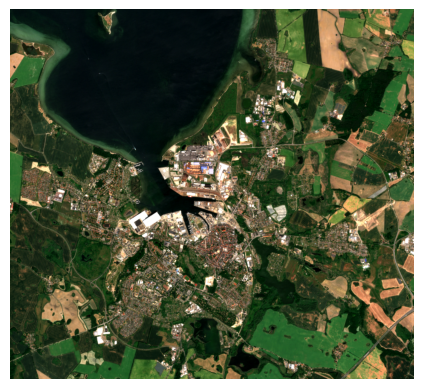

In [18]:
clipped_rgb_arr = np.stack(
    [
        s2_reader.read_band_data_with_clipping(b, wismar_char_gdf.geometry)
        for b in ("B04_10m", "B03_10m", "B02_10m")
    ],
    axis=-1,
)

vis(clipped_rgb_arr, quant_norm=True)

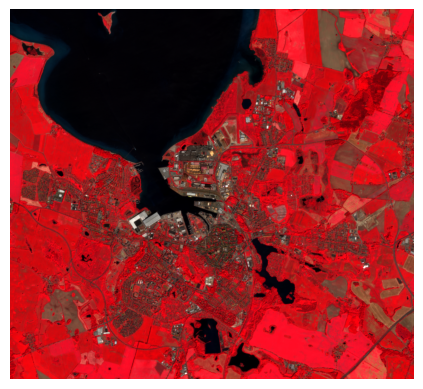

In [19]:
clipped_false_color_arr = np.stack(
    [
        s2_reader.read_band_data_with_clipping(b, wismar_char_gdf.geometry)
        for b in ("B08_10m", "B04_10m", "B03_10m")
    ],
    axis=-1,
)

vis(clipped_false_color_arr, quant_norm=True)

In [20]:
mean_pro_pixel = clipped_rgb_arr.mean(axis=2).flatten()
empty_pixels = np.count_nonzero(mean_pro_pixel == 0)
if empty_pixels > 0:
    print(f"Found {empty_pixels} empty pixels")
else:
    print("No empty pixels found")

No empty pixels found


## 3. Selecting three representative points for three classes.

Select three representative points for three classes in the region of interest (you may hardcode the selection). The classes should be:
1. Water
2. Vegetation
3. Urban

Everything that is not one of the classes (also for the following tasks) we will consider as "Other".

Visualize the region of interest with the three points as markers.
Also, visualize the spectral signature of the three points.

You may use any band resolution you want for the spectral signature visualization.
You can also ignore band 8 for the rest of this homework.

In [21]:
from shapely.geometry import Point

water_point = Point(11.439185, 53.920684)
vegetation_point = Point(11.420952, 53.891644)
# urban_point = Point(11.4680083, 53.8924892)
urban_point = Point(11.461556238464057, 53.89207120544382)

In [22]:
# select the points, explore the points and the region, display the spectral signature

wismar_points_gdf = geopandas.GeoDataFrame(
    {"type": ["water", "vegetation", "urban"]},
    geometry=[water_point, vegetation_point, urban_point],
    crs=f"epsg:{wismar_char_gdf.crs.to_epsg()}"
)
wismar_points_gdf.explore(marker_type="marker")

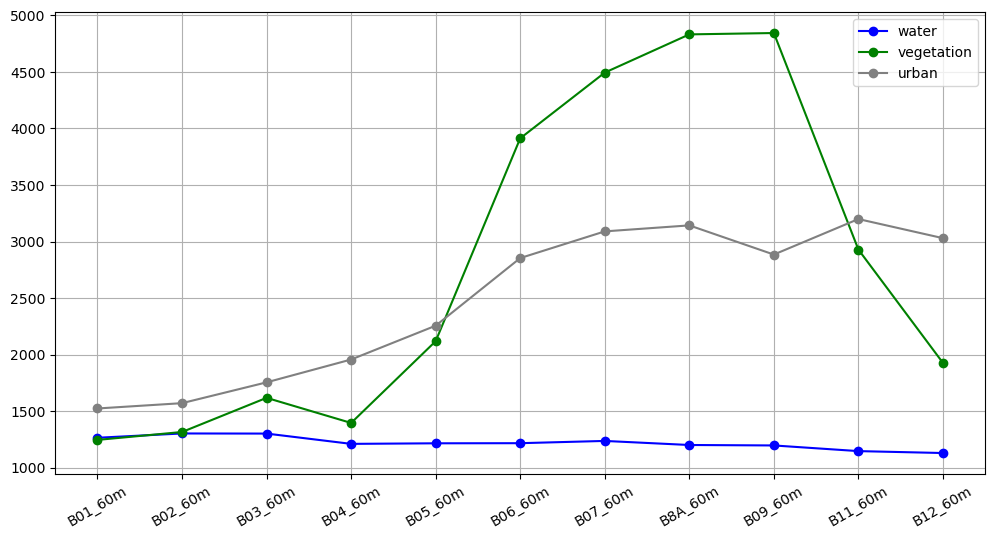

In [23]:
CHOSEN_BANDS = [
    "B01_60m",
    "B02_60m",
    "B03_60m",
    "B04_60m",
    "B05_60m",
    "B06_60m",
    "B07_60m",
    "B8A_60m",
    "B09_60m",
    "B11_60m",
    "B12_60m"
]

water_spectral_sig = np.array([
    s2_reader.read_band_data_with_clipping(b, wismar_points_gdf.query("type == 'water'"))
    for b in CHOSEN_BANDS
])

vegetation_spectral_sig = np.array([
    s2_reader.read_band_data_with_clipping(b, wismar_points_gdf.query("type == 'vegetation'"))
    for b in CHOSEN_BANDS
])

urban_spectral_sig = np.array([
    s2_reader.read_band_data_with_clipping(b, wismar_points_gdf.query("type == 'urban'"))
    for b in CHOSEN_BANDS
])

plt.figure(figsize=(12, 6))
plt.plot(CHOSEN_BANDS, water_spectral_sig, "o-", label="water", color="blue")
plt.plot(CHOSEN_BANDS, vegetation_spectral_sig, "o-", label="vegetation", color="green")
plt.plot(CHOSEN_BANDS, urban_spectral_sig, "o-", label="urban", color="gray")
plt.legend()
plt.xticks(rotation=30)
plt.grid()

## 4. Creating a 3-class pixelwise-classification map (plus discussion).

Create a 3-class pixelwise-classification map for the region of interest. Use the envelope of the region of interest as the area of interest for the classification.
Use the representative points as a very simple approximation for a classifier. 
For each pixel in the region of interest, select one of the classes based on a simple distance measure by your choice (e.g., Euclidean distance). 
Take all bands into account for the classification (except band 8). 
If you think that some bands are more important than others, you can give them more weight in the distance measure.

If any of the pixels in the image are not classified, assign them to the class "Other".

Visualize the classification map and discuss the results.

*Hint: You may interpolate the data to 60m resolution to speed up the classification process and ease the process. 
You only need to interpolate the data if the respective band is not already in the desired resolution.*You only need to interpolate the data if the respective band is not already in the desired resolution.*

In [24]:
import matplotlib

In [25]:
CLASS_WATER = 0
CLASS_VEGETATION = 1
CLASS_URBAN = 2
CLASS_OTHER = 3

ALL_CLASSES = (CLASS_WATER, CLASS_VEGETATION, CLASS_URBAN, CLASS_OTHER)
CLASS_LABELS = {
    CLASS_WATER: "water",
    CLASS_VEGETATION: "vegetation",
    CLASS_URBAN: "urban",
    CLASS_OTHER: "other"
}

In [26]:
all_bands = np.stack(
    [
        s2_reader.read_band_data_with_clipping(b, wismar_char_gdf.geometry)
        for b in CHOSEN_BANDS
    ],
    axis=-1,
)

In [27]:
eucledian_dist = lambda x,y,w: np.sqrt(((x-y)*(x-y)*w).sum())

def classify_pixel_with_weights(weights: np.array):
    def classify_pixel(pixel: np.array):
        if np.count_nonzero(pixel == 0) == pixel.size:
            return CLASS_OTHER
        distances = {
            CLASS_WATER: eucledian_dist(pixel, water_spectral_sig, weights),
            CLASS_VEGETATION: eucledian_dist(pixel, vegetation_spectral_sig, weights),
            CLASS_URBAN: eucledian_dist(pixel, urban_spectral_sig, weights)
        }
        return min(distances, key=distances.get)
    return classify_pixel

def create_classification_map(image, weights):
    classifier = np.vectorize(classify_pixel_with_weights(weights), signature='(n)->()')
    classified_map = classifier(image)
    return classified_map

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


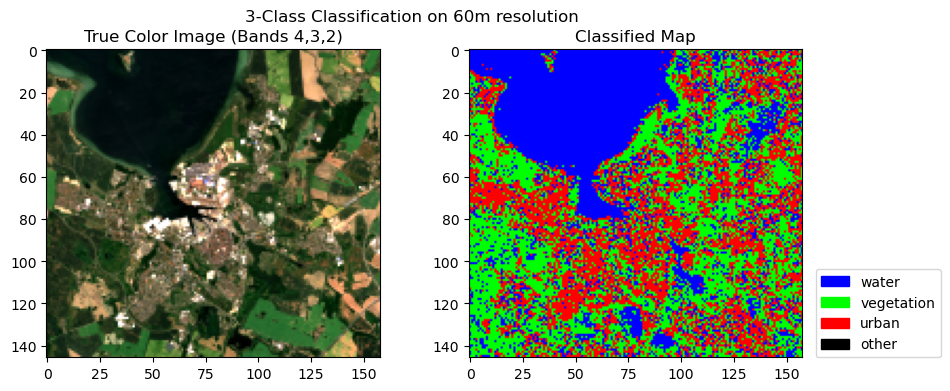

In [28]:
CLASS_COLOR={
    CLASS_WATER: np.array([0,0,255]),
    CLASS_VEGETATION: np.array([0,255,0]),
    CLASS_URBAN: np.array([255,0,0]),
    CLASS_OTHER: np.array([0,0,0])
}

def create_colored_map(classified_map):
    colored_map = np.zeros((classified_map.shape[0],classified_map.shape[1],3))
    colored_map[classified_map == CLASS_WATER] = CLASS_COLOR[CLASS_WATER]
    colored_map[classified_map == CLASS_VEGETATION] = CLASS_COLOR[CLASS_VEGETATION]
    colored_map[classified_map == CLASS_URBAN] = CLASS_COLOR[CLASS_URBAN]
    colored_map[classified_map == CLASS_OTHER] = CLASS_COLOR[CLASS_OTHER]
    return colored_map

def plot_tci_and_classification_map(colored_map):
    fig, axes = plt.subplots(1,2,figsize=(10,4))
    fig.suptitle("3-Class Classification on 60m resolution")
    clipped_rgb_arr_60m = np.stack(
        [
            s2_reader.read_band_data_with_clipping(b, wismar_char_gdf.geometry)
            for b in ("B04_60m", "B03_60m", "B02_60m")
        ],
        axis=-1,
    )

    rgb_img = quant_norm_data(clipped_rgb_arr_60m)
    axes[0].imshow(rgb_img)
    axes[0].set_title("True Color Image (Bands 4,3,2)")
    handles = [matplotlib.patches.Patch(color=CLASS_COLOR[class_id] / 255, label=CLASS_LABELS[class_id]) for class_id in ALL_CLASSES]
    axes[1].imshow(colored_map)
    axes[1].set_title("Classified Map")
    axes[1].legend(handles=handles, loc=(1.04,0))
    plt.show()

weights = np.array([
    1, # "B01_60m"
    2, # "B02_60m"
    2, # "B03_60m"
    2, # "B04_60m"
    1, # "B05_60m"
    2, # "B06_60m"
    2, # "B07_60m"
    2, # "B8A_60m"
    1, # "B09_60m"
    1, # "B11_60m"
    1, # "B12_60m"
])
    

classified_map = create_classification_map(all_bands, weights)
colored_map = create_colored_map(classified_map)
plot_tci_and_classification_map(colored_map)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


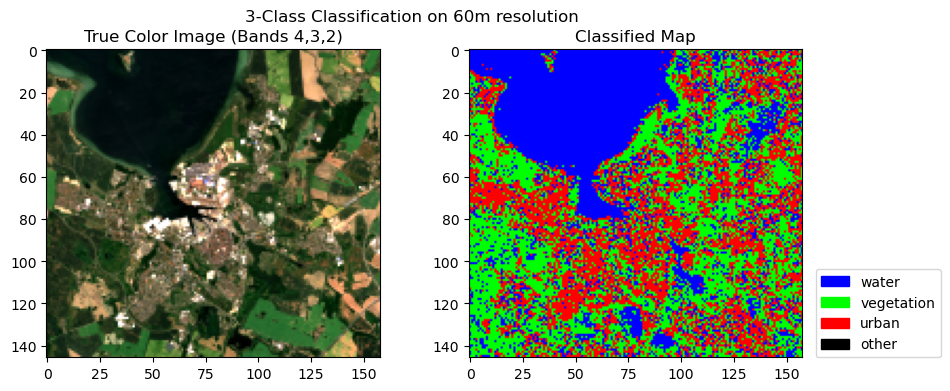

In [29]:
CLASS_COLOR={
    CLASS_WATER: np.array([0,0,255]),
    CLASS_VEGETATION: np.array([0,255,0]),
    CLASS_URBAN: np.array([255,0,0]),
    CLASS_OTHER: np.array([0,0,0])
}

def create_colored_map(classified_map):
    colored_map = np.zeros((classified_map.shape[0],classified_map.shape[1],3))
    colored_map[classified_map == CLASS_WATER] = CLASS_COLOR[CLASS_WATER]
    colored_map[classified_map == CLASS_VEGETATION] = CLASS_COLOR[CLASS_VEGETATION]
    colored_map[classified_map == CLASS_URBAN] = CLASS_COLOR[CLASS_URBAN]
    colored_map[classified_map == CLASS_OTHER] = CLASS_COLOR[CLASS_OTHER]
    return colored_map

def plot_tci_and_classification_map(image, colored_map, title_suffix=""):
    fig, axes = plt.subplots(1,2,figsize=(10,4))
    title = "3-Class Classification on 60m resolution" + title_suffix
    fig.suptitle(title)

    rgb_img = quant_norm_data(image)
    axes[0].imshow(rgb_img)
    axes[0].set_title("True Color Image (Bands 4,3,2)")
    handles = [matplotlib.patches.Patch(color=CLASS_COLOR[class_id] / 255, label=CLASS_LABELS[class_id]) for class_id in ALL_CLASSES]
    axes[1].imshow(colored_map)
    axes[1].set_title("Classified Map")
    axes[1].legend(handles=handles, loc=(1.04,0))
    plt.show()
    
colored_map = create_colored_map(classified_map)
clipped_rgb_arr_60m = np.stack(
        [
            s2_reader.read_band_data_with_clipping(b, wismar_char_gdf.geometry)
            for b in ("B04_60m", "B03_60m", "B02_60m")
        ],
        axis=-1,
    )
plot_tci_and_classification_map(clipped_rgb_arr_60m, colored_map)

### Discussion

Do you think the points are representative for the classes? Why?
What are the strengths and weaknesses of this classification?
What could be done to improve the classification?

Expected extend: 2 short paragraphs (6-10 sentences)
---
The point for "water" class is a good representation, since water pixels don't vary much, however shadows sometimes are similar to the water in some bands. Furthermore, the pixels for "vegetation" and "urban" classes do not generalize the classes very well, since different vegetation and urban areas can vary in selected bands. A pixel of "urban" true class can be recognized as "vegetation", in case there is some green on the street and the resolution doesn't allow to recognize a difference. Wismar's landscape is various across the area and pixel from same class may have different signatures.  

The classification process is fast and simple, however the model that uses only Eucledian distance as a metric doesn't generalize the classes very well. For a better classification we would need a bigger dataset (train/test) and method like k-Nearest Neighbor

# 5. Applying a smoothing filter

In this task you should create a kernel that smoothest the image in hopes to make the second classification less noisy.
You may use scipy convolution to apply the filter.

In [30]:
# apply a smoothing filter
kernel = np.ones((3,3), dtype=np.float32)
kernel[1,1] = -7

kernel = np.array([
    [1, 2, 2, 1],
    [2, 3, 3, 2],
    [2, 3, 3, 2],
    [1, 2, 2, 1]
])
kernel = kernel / kernel.sum()

(146, 158, 11)


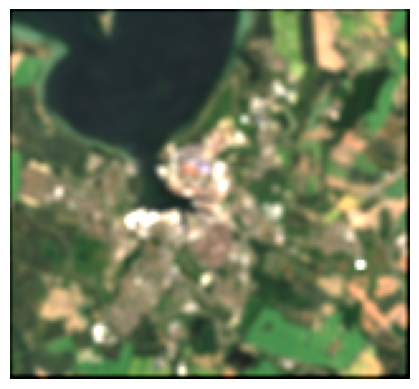

In [31]:
from scipy.ndimage import convolve
print(all_bands.shape)
smooth_img = np.zeros_like(all_bands)
for channel in range(all_bands.shape[2]):
    smooth_img[:,:,channel] = convolve(all_bands[:,:,channel], kernel, mode="constant")
    
rgb_img_smooth = np.stack([
    smooth_img[:,:,3],
    smooth_img[:,:,2],
    smooth_img[:,:,1],
], axis=-1)
vis(rgb_img_smooth, True)


# 6. Recreate the 3-class pixelwise-classification map (plus discussion of differences).

Recreate the 3-class pixelwise-classification map for the smoothed image. You should use the same representative points and functions as in task 4 for the classification.
Display the original and smoothed image and the classification (e.g., in a 2x2 grid) to compare the results.

*Note: Do not smooth the classification map. Instead, smooth the image and classify again.*

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


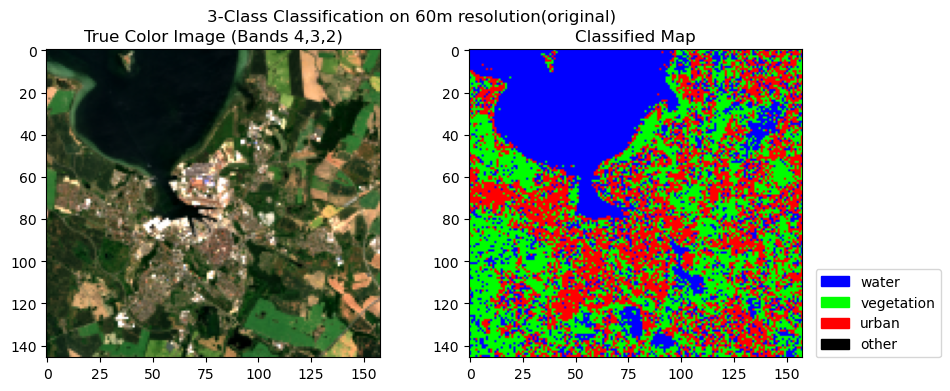

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


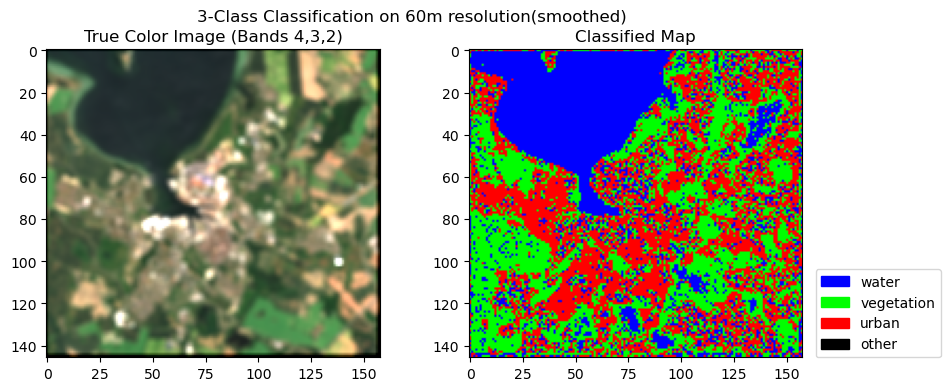

In [32]:
# smooth the image, show original, smoothed, classified(original) and classified (smoothed) images
classified_map_smooth = create_classification_map(smooth_img, weights)
colored_map_smooth = create_colored_map(classified_map_smooth)
plot_tci_and_classification_map(clipped_rgb_arr_60m, colored_map, "(original)")
plot_tci_and_classification_map(rgb_img_smooth, colored_map_smooth, "(smoothed)")

### Discussion

Why did you choose this kernel? 
What is the effect of the kernel on the image? 
How does the classification change?
Do you think the classification is better after applying the filter?

Expected extend: 2 short paragraphs (6-10 sentences)
---

The kernel smoothens the image, averages the values of surrounding pixels. 4x4 kernel uses more surrounding pixels than 3x3 and puts more emphasis on the nearest pixels. Pixels from all sides affect the pixel value, which is important due to Wismar's unstructured landscape (streets, districts and roads have non-trivial form) 

The classification now includes less noise, and as a result there are more more whole regions of the same class. It looks like the classification has become better, since we can recognize some areas from the true color image on the classification map (for example vegetation areas). However areas with low vegetation are still often misclassified, since smoothening didn't solve the problem of bad generalization

# 7. Creating a binary pixelwise-classification map and run edge detection (plus discussion).

Create a binary pixelwise-classification map for the region of interest. Use the envelope of the region of interest as the area of interest for the classification.
You may use the classification from task 4 or task 6 for this task.

The binary classification should have the following classes:
1. belong to the class X (X is one of the classes from task 4 or task 6)
2. do not belong to the class X.

After creating the binary classification, apply edge detection to the binary classification map.
You may not use a well-known edge detection filter (e.g., Sobel, Canny, etc.) for this task, but create your own edge detection filter.
You may again use the scipy convolution to apply the filter.

Visualize the binary classification map, the edge detection map, the used classification map, and the true color image used for the classification.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Edge Detection')

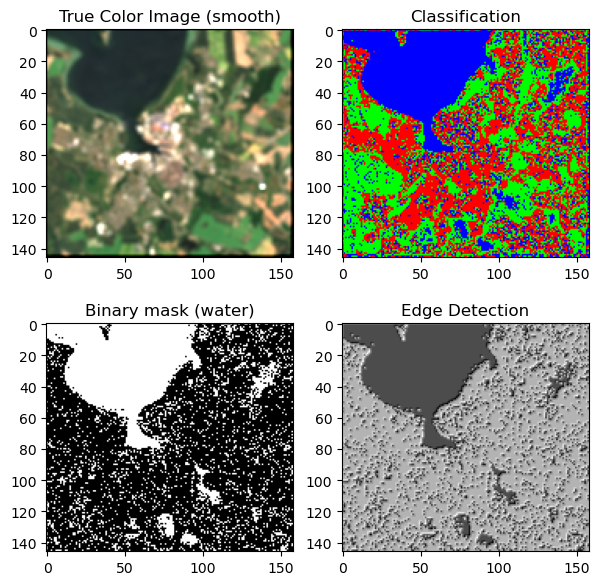

In [33]:
import scipy
import scipy.ndimage 

map_binary = np.zeros((classified_map.shape[0],classified_map.shape[1]))
map_binary[classified_map == CLASS_WATER] = 1.0
map_binary[classified_map != CLASS_WATER] = 0.0

kernel_edges = np.array([
    [1,1,0],
    [1,-4,-1],
    [0,-1,-1]
])
map_binary_edges = convolve(map_binary, kernel_edges, mode="constant")

fig, axes = plt.subplots(2, 2, figsize=(7, 7))
rgb_img_smooth_quant = quant_norm_data(rgb_img_smooth)
axes[0][0].imshow(rgb_img_smooth_quant)
axes[0][0].set_title("True Color Image (smooth)")
axes[0][1].imshow(colored_map_smooth)
axes[0][1].set_title("Classification")
axes[1][0].imshow(map_binary, cmap="gray")
axes[1][0].set_title("Binary mask (water)")
axes[1][1].imshow(map_binary_edges, cmap="gray")
axes[1][1].set_title("Edge Detection")

### Discussion

Why did you choose this kernel for the edge detection?
What is the effect of the kernel on the binary classification map?
Do you think the edge detection is successful?
Which map did you use for the edge detection and why?

Expected extend: 2 short paragraphs (6-10 sentences)

*Write your discussion here...*

## Submission

- Follow the instructions mentioned in this notebook.
- You are _not_ allowed to install other libraries.
- Explain the steps that went into the decision-making of the specific values if applicable in the respective discussions.
- It is essential that each homework should be done individually! We will check for plagiarism.
- The notebook should have been executed once before submitting it
    - The notebook should _not_ be _cleaned_ before submitting
    - Before the final submission, delete all intermediate files (e.g. downloaded files) and then "Restart the kernel and run all cells" (⏩ in the top left)
- Do not submit your copernicus secret!

Each student should submit the following materials to the ISIS system:
- One `zip` file containing the jupyter notebook named as: `IP4RS2024-HW1_<NAME_SURNAME>.zip`, e.g. `IP4RS2024-HW1_Riley_Exampleperson.zip` and nothing else.
